<a href="https://colab.research.google.com/github/BEMiklos/PlantTraits2024/blob/main/Inferences_and_ensamble_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from lime import lime_image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_checkpoint(checkpoint_file, model, device):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

#Dataset

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c planttraits2024

100% 3.16G/3.17G [00:39<00:00, 104MB/s]
100% 3.17G/3.17G [00:39<00:00, 86.8MB/s]


In [ ]:
!unzip -q '/content/planttraits2024.zip'

In [ ]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random_state = 7

np.random.seed(0)

random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset, random_split

In [ ]:
import albumentations as A
import cv2

In [ ]:
TRAIN_IMAGES_PATH = '/content/train_images'
TEST_IMAGES_PATH = '/content/test_images'

In [ ]:
mean_pattern = r'X\d+_mean'
sd_pattern = r'X\d+_sd'

In [ ]:
def find_matching_elements(lst,pattern):
    matching_elements = [element for element in lst if re.search(pattern, element)]
    return matching_elements

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
def split_dataframe(train_df, test_df, train_size=0.8, val_size=0.2):
    if train_size + val_size != 1:
        raise ValueError("train_size, val_size, and test_size must sum to 1")

    train_df, val_df = train_test_split(train_df, train_size=train_size, random_state=random_state)
    return train_df, val_df, test_df

In [ ]:
class AlbumentationsTransform:
    def __init__(self, augmentation):
        self.augmentation = augmentation

    def __call__(self, img):
        img_np = np.array(img)
        augmented = self.augmentation(image=img_np)
        return augmented['image']

train_augmentation =A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.Rotate(limit=45, p=0.5),
          A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
          A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
          A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
          A.Resize(224, 224)
        ])
# train_augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Rotate(limit=45, p=0.5),
#     A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
#     # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.2),
#     # A.ElasticTransform(alpha=1, sigma=15, alpha_affine=15, p=0.2),
#     # A.GaussianBlur(blur_limit=3, p=0.5),
#     # A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
#     #A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
#     A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
#     # A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=50, p=0.5),
#     A.Resize(256, 256)
# ])

test_val_augmentation = A.Compose([
    A.Resize(224, 224) # ViT 224
])

final_transforms = transforms.Compose([
    AlbumentationsTransform(test_val_augmentation), #Ez miért kell?
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
class PlantTraits2024_Dataset(Dataset):
    def __init__(self, df, columns, images_path, augmentation=None,
                 transform=None, augment_times=1, metadata_columns=None,
                 augment_metadata=False,
                 metadata_augmentation_std=0.1, target = None):

        self.df = df
        self.columns = columns
        self.images_path = images_path
        self.augmentation = augmentation
        self.transform = transform
        self.augment_times = augment_times
        self.augment_metadata = augment_metadata
        self.metadata_augmentation_std = metadata_augmentation_std
        self.target = target

    def __len__(self):
        return len(self.df) * self.augment_times

    def __getitem__(self, idx) :
        original_idx = idx // self.augment_times
        id = self.df.iloc[original_idx, 0]
        image_path = f'{self.images_path}/{id}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        filtered_df = self.df[self.df['id'] == id].iloc[0]

        meta_data = torch.as_tensor(filtered_df[self.columns].to_numpy().astype(np.float64))

        if (self.augment_metadata):
          meta_data = self.augment_tabular_data(meta_data)

        if self.augmentation:
            image = AlbumentationsTransform(self.augmentation)(image)

        if self.transform:
            image = self.transform(image)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]

    def augment_tabular_data(self, meta_data):
        noise = np.random.normal(0, self.metadata_augmentation_std, meta_data.shape)
        augmented_meta_data = meta_data # + noise
        return torch.as_tensor(augmented_meta_data, dtype=torch.float32)

    def get_original_image_and_metadata(self, idx):
        image_name = self.df.iloc[idx, 0]
        image_path = f'{self.images_path}/{image_name}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

        meta_data = self.df.iloc[idx][self.columns].to_numpy().astype(np.float64)
        meta_data = torch.tensor(meta_data, dtype=torch.float64)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]

In [ ]:
targets = [col for col in train_df.columns if col not in test_df.columns]
targets = targets[:6]
metadata_columns = [col for col in train_df.columns if col in test_df.columns and col != 'id']

In [ ]:
def create_dataset(train_df, test_df, columns, targets, train_images_path, test_images_path, augment_times, train_augmentation):
    # A képeknek csak a 10% át vesszük, hogy le tudjon futni Colabon a tanítás!!!
    train_df, val_df, test_df = split_dataframe(train_df.sample(frac=0.1, random_state=1), test_df)
    target = [i-1 for i, col in enumerate(train_df.columns) if col not in test_df.columns]
    target = target[:6]
    train_dataset = PlantTraits2024_Dataset(train_df, columns + targets, train_images_path, augmentation=train_augmentation, transform=final_transforms, augment_times=augment_times, augment_metadata=True,target=target)
    val_dataset = PlantTraits2024_Dataset(val_df, columns + targets, train_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=1, target=target)
    test_dataset = PlantTraits2024_Dataset(test_df, columns, test_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=1, target=target)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = create_dataset(train_df, test_df, metadata_columns, targets, TRAIN_IMAGES_PATH, TEST_IMAGES_PATH, augment_times=2, train_augmentation=train_augmentation)


In [ ]:
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=False)

# Explainability

In [ ]:
def model_predict(input_imgs):
    model.eval()  # Make sure the model is in evaluation mode
    input_imgs_tensor = torch.tensor(input_imgs, dtype=torch.float32).permute(0, 3, 1, 2).div(255).to(device)  # Normalize and convert to tensor

    with torch.no_grad():
        preds = model(input_imgs_tensor)
        preds = preds.cpu().numpy()  # Convert predictions to numpy array

    # Force the output to be 2D [samples, targets]
    if preds.ndim == 1:
        preds = preds.reshape(-1, 1)
    elif preds.ndim == 2 and preds.shape[1] == 1:
        preds = preds.reshape(-1, 1)
    elif preds.ndim == 2 and preds.shape[1] > 1:
        preds = preds  # It should be already in the correct shape
    else:
        raise ValueError(f"Unexpected prediction shape {preds.shape}, which cannot be handled.")

    return preds

In [109]:
def explain_instance_with_lime(image, model, num_features, num_samples, hide_rest):
    """
    Explain an image instance using LIME for a regression model.
    """
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
      image,
      classifier_fn=lambda x: model_predict(x),
      top_labels=1,
      hide_color=0 if hide_rest else None,
      num_features=num_features,
      num_samples=num_samples
  )

    temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=10,
                                                hide_rest=hide_rest)
    img_boundary = mark_boundaries(temp / 2 + 0.5, mask)
    return img_boundary


In [112]:
def load_checkpoint(checkpoint_file, model, device):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    state_dict = checkpoint['model_state_dict']

    # Adjust the keys in the state dictionary
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = 'network.' + key if not key.startswith('network.') else key
        new_state_dict[new_key] = value

    # Load the adjusted state dictionary into the model
    model.load_state_dict(new_state_dict)
    return model

In [206]:
class PlantTraitsPretrainedVisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = models.vit_b_16(pretrained=True)

    self.network.heads.head = nn.Linear(self.network.heads.head.in_features, 6, bias=True)

  def forward(self, xb):
    return self.network(xb)

checkpoint_path = '/content/drive/MyDrive/best_model.pth.tar'
model = PlantTraitsPretrainedVisionTransformer()
model = load_checkpoint(checkpoint_path, model, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [207]:
model = model.to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

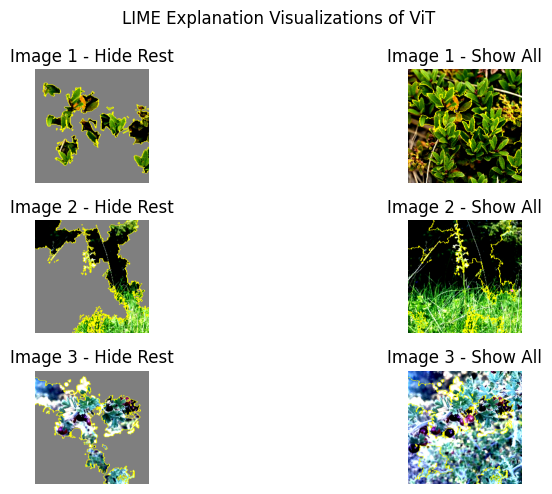

In [ ]:
images_to_show = []
for i in range(3):
  for hide_rest in [True, False]:
    image = test_dataset[i][0].permute(1, 2, 0).numpy()
    if np.max(image) <= 1:
      image = (image * 255).astype(np.uint8)
    img_boundry = explain_instance_with_lime(image, model, num_features=1000, num_samples=1000, hide_rest=hide_rest)
    images_to_show.append(img_boundry)

num_images = len(images_to_show)
cols = 2
rows = (num_images + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(10, 5))
fig.suptitle('LIME Explanation Visualizations of ViT')

axs = axs.ravel()

for idx, img in enumerate(images_to_show):
    axs[idx].imshow(img)
    title = "Image {} - {}".format(idx // 2 + 1, "Hide Rest" if idx % 2 == 0 else "Show All")
    axs[idx].set_title(title)
    axs[idx].axis('off')

for ax in axs[len(images_to_show):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Test_VGG

In [ ]:
def load_checkpoint(checkpoint_file, model, device):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    state_dict = checkpoint['model_state_dict']

    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace('network.', '')
        new_state_dict[new_key] = value

    model.load_state_dict(new_state_dict)
    return model

In [ ]:
class PlantTraitsPretrainedVGG16(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)

        self.features = vgg16.features

        self.classifier = nn.Sequential(
           nn.Linear(25088, 4096),
           nn.ReLU(inplace=True),
           nn.Dropout(0.3),
           nn.Linear(4096, 2048),
           nn.ReLU(inplace=True),
           nn.Dropout(0.3),
           nn.Linear(2048, 6),
        )

        self.gradients = None
        self.requires_grad = False

    def activations_hook(self, grad):
        if self.requires_grad:
            self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        if self.requires_grad:
          h = x.register_hook(self.activations_hook)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features(x)

checkpoint_path = '/content/drive/MyDrive/best_vgg_model.pth.tar'
model = PlantTraitsPretrainedVGG16().to(device)
model = load_checkpoint(checkpoint_path, model, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

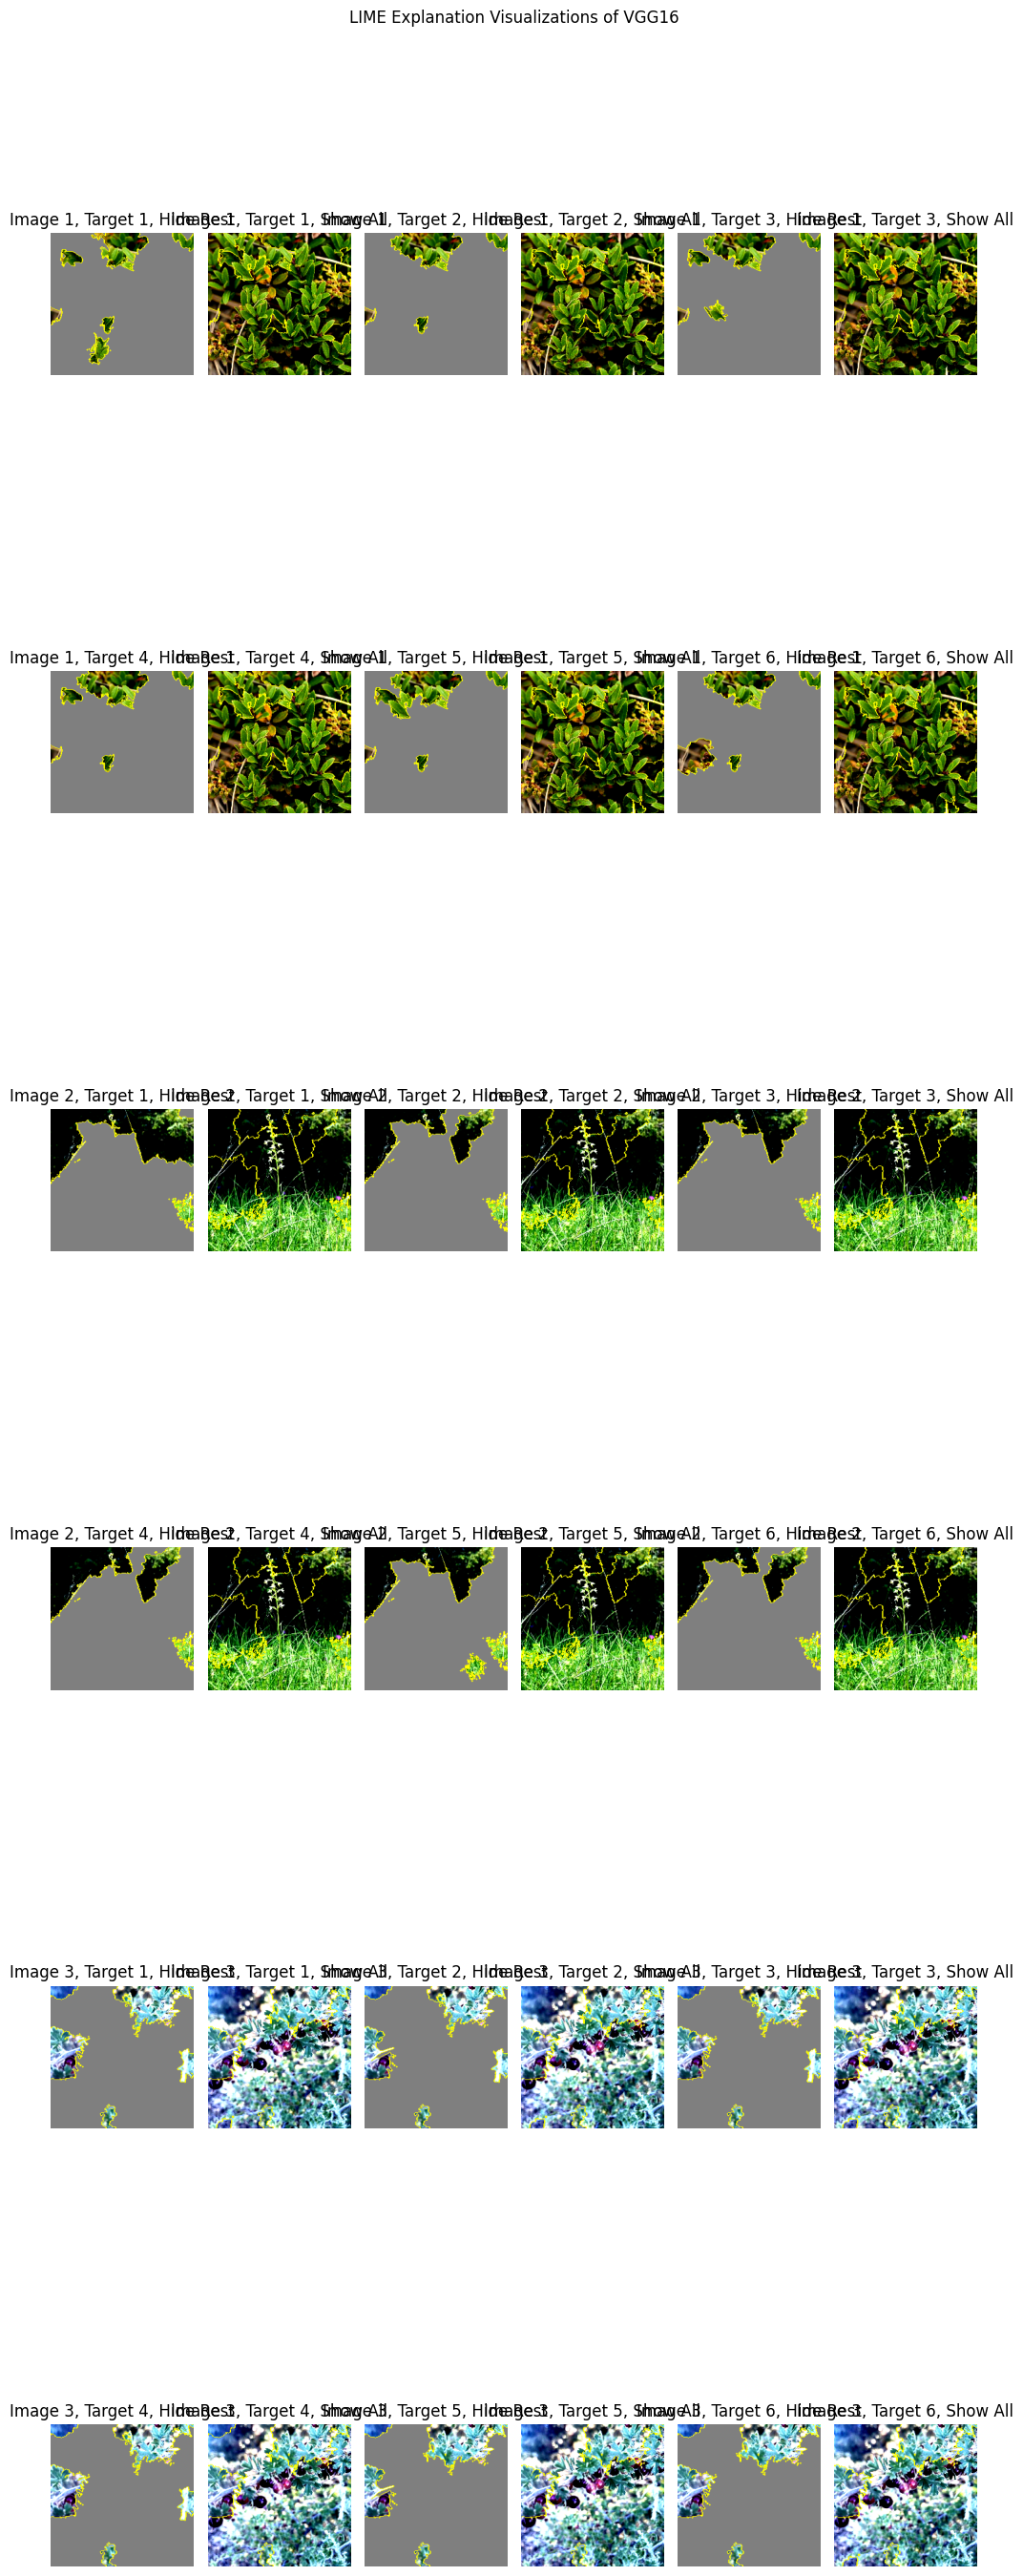

In [110]:
images_to_show = []
for i in range(3):  # Assuming you have 3 images in your test_dataset
    for target_idx in range(6):  # Assuming the model predicts 6 different targets
        for hide_rest in [True, False]:
            image = test_dataset[i][0].permute(1, 2, 0).numpy()
            if np.max(image) <= 1:
                image = (image * 255).astype(np.uint8)
            # Ensure you pass the 'target_idx' here:
            img_boundary = explain_instance_with_lime(image, model, num_features=1000, num_samples=1000, hide_rest=hide_rest)
            images_to_show.append(img_boundary)

# Visualization code remains the same
num_images = len(images_to_show)
cols = 6
rows = 6

fig, axs = plt.subplots(rows, cols, figsize=(10, 5 * rows))
fig.suptitle('LIME Explanation Visualizations of VGG16')

axs = axs.ravel()

for idx, img in enumerate(images_to_show):
    axs[idx].imshow(img)
    title = f"Image {idx // 12 + 1}, Target {(idx // 2) % 6 + 1}, {'Hide Rest' if (idx % 2) == 0 else 'Show All'}"
    axs[idx].set_title(title)
    axs[idx].axis('off')

for ax in axs[len(images_to_show):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image

def apply_colormap_on_image(org_img, activation, colormap_name='jet'):
    no_trans_heatmap = activation.cpu().numpy()
    no_trans_heatmap = (no_trans_heatmap - np.min(no_trans_heatmap)) / (np.max(no_trans_heatmap) - np.min(no_trans_heatmap))

    colormap = plt.get_cmap(colormap_name)
    heatmap = colormap(no_trans_heatmap)
    heatmap = np.uint8(255 * heatmap)[:, :, :3]
    heatmap = Image.fromarray(heatmap)

    heatmap = heatmap.resize(org_img.size, Image.LANCZOS)

    heatmap_on_image = Image.blend(org_img.convert("RGBA"), heatmap.convert("RGBA"), alpha=0.5)
    return heatmap_on_image


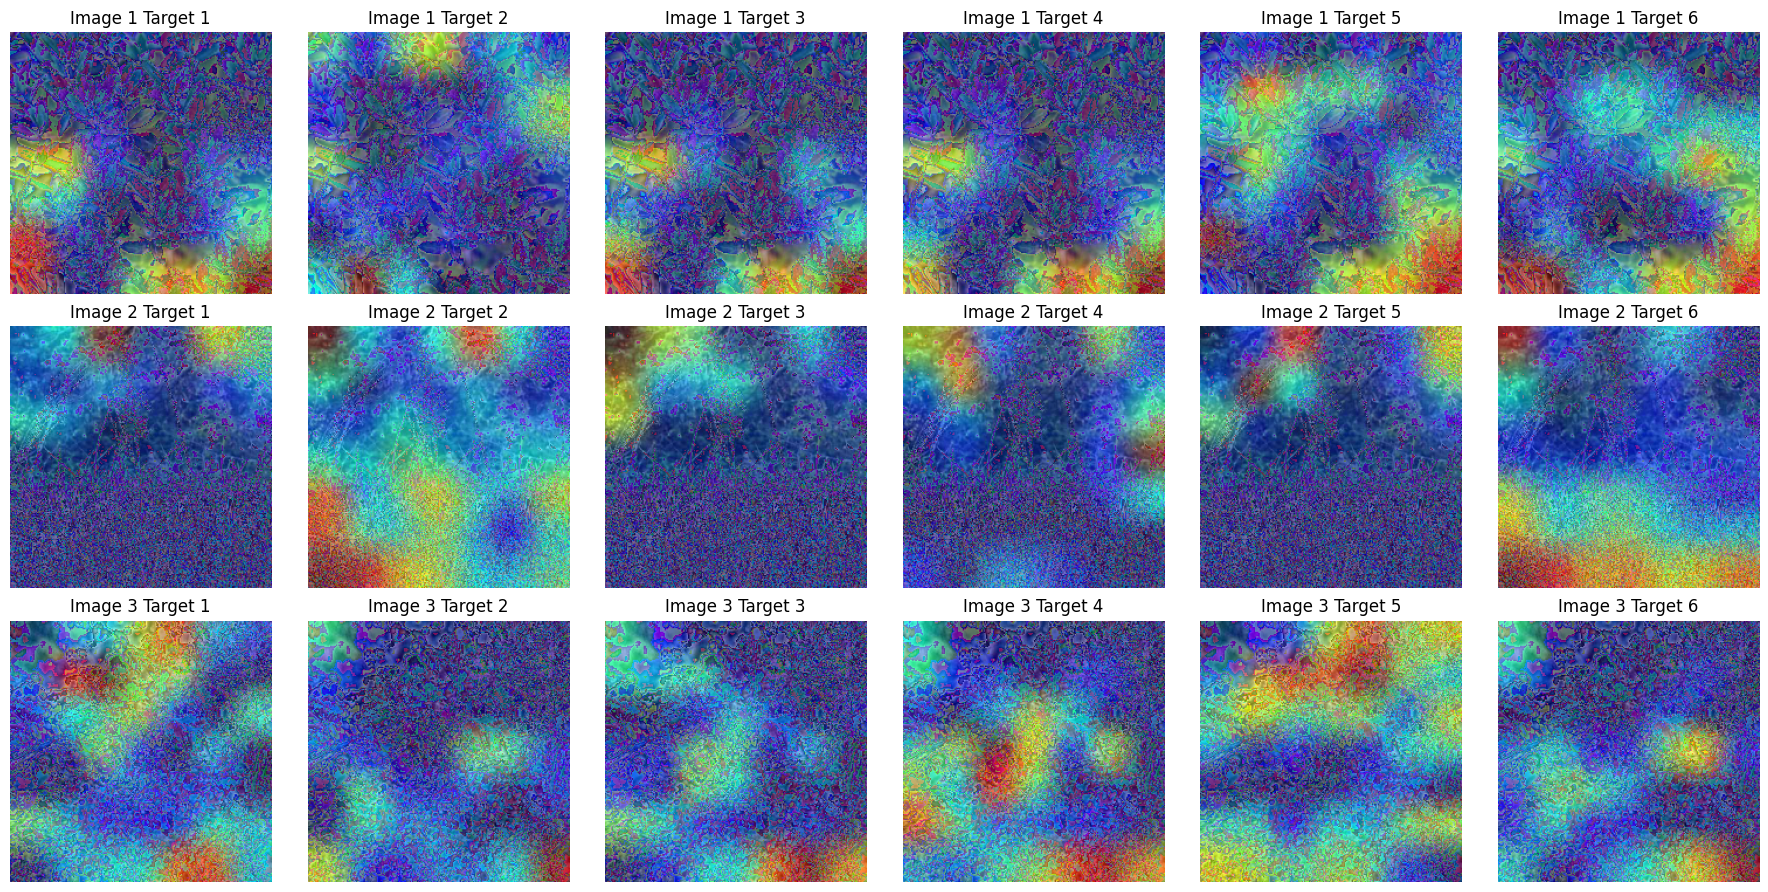

In [ ]:
model.eval()
fig, axs = plt.subplots(3, 6, figsize=(18, 9))

for i in range(3):
    img = test_dataset[i][0]
    img_tensor = img.unsqueeze(0).to(device)
    img_pil = transforms.ToPILImage()(img)

    for j in range(6):
        output = model(img_tensor)
        target = output[:, j]
        target.backward(retain_graph=True)

        gradients = model.get_activations_gradient()
        activations = model.get_activations(img_tensor).detach()
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        for k in range(activations.shape[1]):
            activations[:, k, :, :] *= pooled_gradients[k]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        heatmap_on_image = apply_colormap_on_image(img_pil, heatmap)

        ax = axs[i, j]
        ax.imshow(heatmap_on_image)
        ax.axis('off')
        ax.set_title(f'Image {i+1} Target {j+1}')

plt.tight_layout()
plt.show()